In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/SolarEnergy/SolarPrediction.csv


### Table of Contents
1. [Importing libraries](#import)
2. [Loading Data](#load)
3. [Data Wrangling](#wrangle)
4. [Feature Selection using Correlation Matrix](#correlation)
5. [Feature Selection using SelectKBest Method](#selectkbest)
6. [Feature Selection using Extra Tree Classifier](#extratree)
7. [Feature Engineering with BoxCox, Log, Min-Max and Standard Transformation](#boxcox)
8. [Visualization of transformers](#transformers)
9. [Preparing Data - Standardisation and Splitting](#standardize)
10.[Prediction with XGBoost](#xgboost)
11.[Using MultiLayer Percepton for Prediction](#perceptron)

## Importing libraries<a name='import'></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
import xgboost as xgb

from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.models import Sequential

from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Loading the Data <a name="load"></a>

In [3]:
data = pd.read_csv("/kaggle/input/SolarEnergy/SolarPrediction.csv")
data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


## Data Wrangling <a name="wrangle"></a>

In [5]:
df = data.copy()

**Extracting Date from the Date-Time Format (Data column)**

In [6]:
st = '9/29/2016 12:00:00 AM'
st.split()[0]

'9/29/2016'

In [7]:
# lambda functions works as an iterator
df['Data'] = df['Data'].apply(lambda x: x.split()[0])

In [8]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


Extraction of Date and Month from **Data** and Hour, Minute and second from **Time**

In [9]:
df["Month"]    = pd.to_datetime(df['Data']).dt.month
df['Day']      = pd.to_datetime(df['Data']).dt.day
df['Hour']     = pd.to_datetime(df['Time']).dt.hour
df['Minute']   = pd.to_datetime(df['Time']).dt.minute
df['Second']   = pd.to_datetime(df['Time']).dt.second

In [10]:
df.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second
0,1475229326,9/29/2016,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00,9,29,23,55,26
1,1475229023,9/29/2016,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00,9,29,23,50,23
2,1475228726,9/29/2016,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00,9,29,23,45,26
3,1475228421,9/29/2016,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00,9,29,23,40,21
4,1475228124,9/29/2016,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00,9,29,23,35,24


**Extracting Hour and Minute from TimeSunRise and TimeSunSet using regular expression**

In [11]:
# ^\d : we don't want to extract anything which is not a digit
df['riseHour']   = df['TimeSunRise'].apply(lambda x: int(re.search(r'^(\d+):', x).group(1)))
df['riseMinute'] = df['TimeSunRise'].apply(lambda x: int(re.search(r'(?<=\:)\d+(?=\:)', x).group(0)))

df['setHour']   = df['TimeSunSet'].apply(lambda x: int(re.search(r'^\d+', x).group(0)))
df['setMinute'] = df['TimeSunSet'].apply(lambda x: int(re.search(r'(?<=\:)\d+(?=\:)', x).group(0)))

In [12]:
df.tail()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet,Month,Day,Hour,Minute,Second,riseHour,riseMinute,setHour,setMinute
32681,1480587604,12/1/2016,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00,12,1,0,20,4,6,41,17,42
32682,1480587301,12/1/2016,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00,12,1,0,15,1,6,41,17,42
32683,1480587001,12/1/2016,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00,12,1,0,10,1,6,41,17,42
32684,1480586702,12/1/2016,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00,12,1,0,5,2,6,41,17,42
32685,1480586402,12/1/2016,00:00:02,1.20,44,30.43,101,83.59,3.37,06:41:00,17:42:00,12,1,0,0,2,6,41,17,42


In [13]:
# Dropping parameters that are not required
df.drop(['UNIXTime','Data','Time','TimeSunRise','TimeSunSet'],axis=1,inplace=True)

In [14]:
df.shape

(32686, 15)

In [15]:
# Checking for null values in the dataset
df.isnull().sum()

Radiation                 0
Temperature               0
Pressure                  0
Humidity                  0
WindDirection(Degrees)    0
Speed                     0
Month                     0
Day                       0
Hour                      0
Minute                    0
Second                    0
riseHour                  0
riseMinute                0
setHour                   0
setMinute                 0
dtype: int64

In [16]:
input_features = df.drop(['Radiation'],axis=1)
target = df['Radiation']

 ## Feature Selection using Correlation Matrix<a name="correlation"></a> 

In [17]:
corr_matrix = df.corr()
corr_matrix

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,riseHour,riseMinute,setHour,setMinute
Radiation,1.000000,0.734955,0.119016,-0.226171,-0.230324,0.073627,-0.095450,0.039978,0.004398,-0.000730,-0.031270,NaN,-0.092850,0.048719,-0.039816
Temperature,0.734955,1.000000,0.311173,-0.285055,-0.259421,-0.031458,-0.354560,-0.123705,0.197464,-0.001934,-0.036147,NaN,-0.380968,0.300920,-0.242881
Pressure,0.119016,0.311173,1.000000,-0.223973,-0.229010,-0.083639,-0.341759,-0.024633,0.091069,0.001860,-0.031102,NaN,-0.380399,0.151939,-0.119599
Humidity,-0.226171,-0.285055,-0.223973,1.000000,-0.001833,-0.211624,-0.068854,0.014637,0.077899,0.000499,-0.027682,NaN,-0.023955,0.145143,-0.119526
WindDirection(Degrees),-0.230324,-0.259421,-0.229010,-0.001833,1.000000,0.073092,0.181485,-0.082354,-0.077969,-0.000602,-0.032568,NaN,0.176929,-0.078540,0.070030
Speed,0.073627,-0.031458,-0.083639,-0.211624,0.073092,1.000000,0.150822,0.117337,-0.057939,0.000192,-0.032934,NaN,0.167075,-0.159384,0.119926
Month,-0.095450,-0.354560,-0.341759,-0.068854,0.181485,0.150822,1.000000,0.038027,-0.005396,0.000168,0.220563,NaN,0.952472,-0.784783,0.541883
Day,0.039978,-0.123705,-0.024633,0.014637,-0.082354,0.117337,0.038027,1.000000,-0.008010,-0.000196,0.089078,NaN,0.274522,-0.263575,0.265662
Hour,0.004398,0.197464,0.091069,0.077899,-0.077969,-0.057939,-0.005396,-0.008010,1.000000,-0.004052,0.004199,NaN,-0.006772,0.008629,-0.007056
Minute,-0.000730,-0.001934,0.001860,0.000499,-0.000602,0.000192,0.000168,-0.000196,-0.004052,1.000000,0.002517,NaN,-0.000158,0.001052,-0.002215


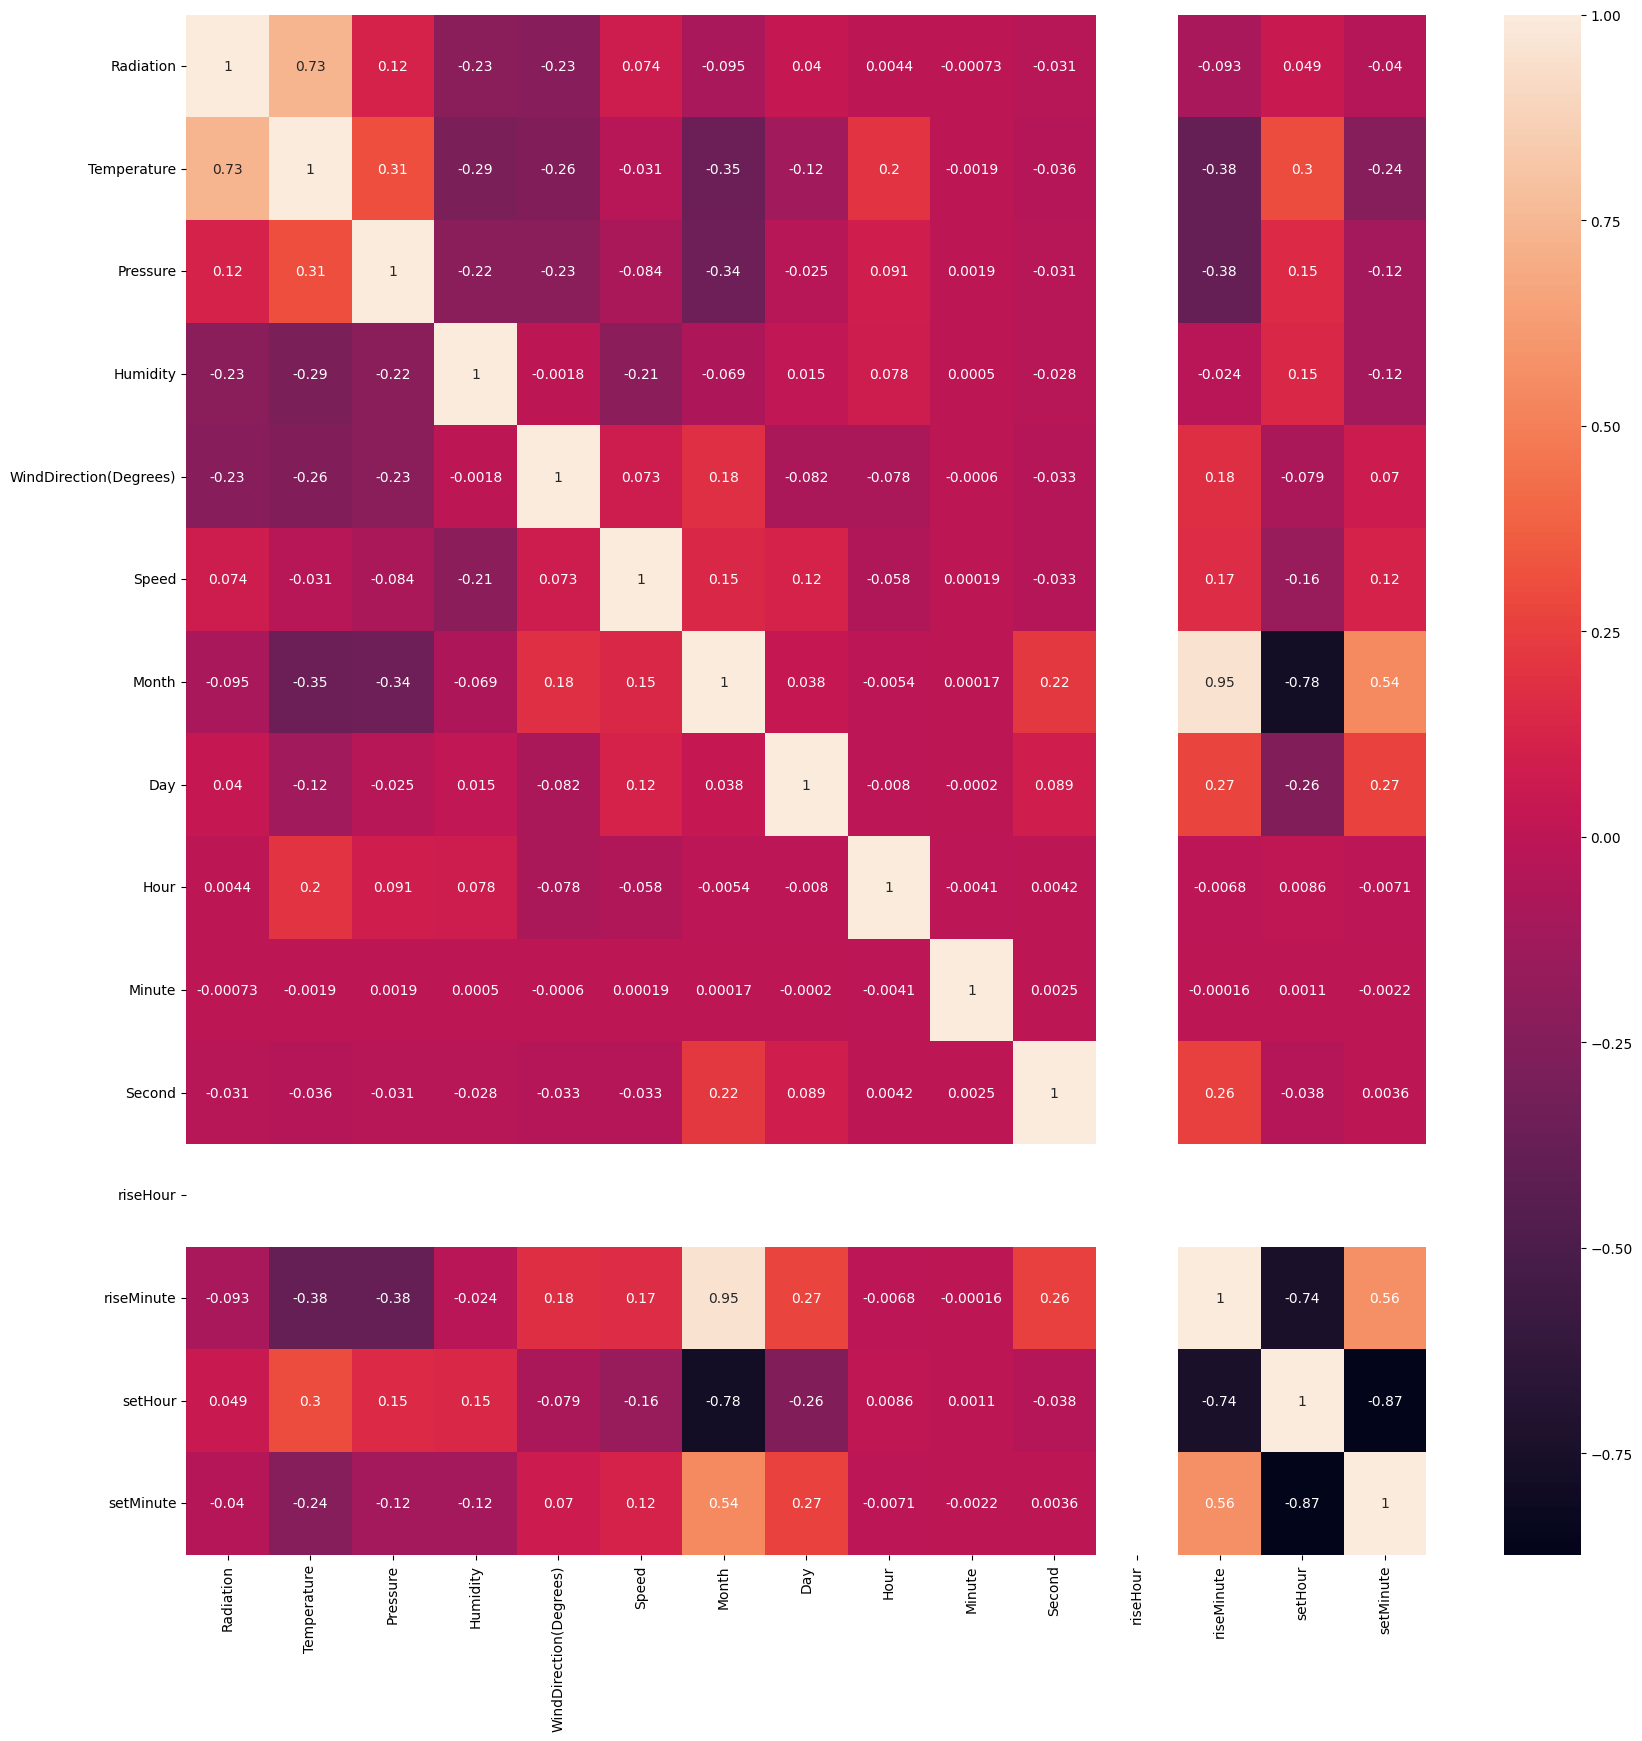

In [18]:
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(),annot=True)
plt.show()

**Since there is only one unique value (i.e., 6) in the 'riseHour' column,the standard deviation is zero, leading to NaN correlations**.

## Feature Selection using SelectKBest Method <a name="selectkbest"></a>

In [19]:
# Select top features
bestfeatures = SelectKBest(score_func = chi2,k=10)

In [20]:
# Converting float values to labelled format
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_Y = label_encoder.fit_transform(target)

In [21]:
target[:5]

0    1.21
1    1.21
2    1.23
3    1.21
4    1.17
Name: Radiation, dtype: float64

In [22]:
# Multiplying each target value by 100 to convert it into integer
target_count = df["Radiation"].apply(lambda x:int(x*100))

In [23]:
train_Y

array([ 9,  9, 11, ...,  8, 11,  8])

In [24]:
target_count

0        121
1        121
2        123
3        121
4        117
        ... 
32681    122
32682    117
32683    120
32684    123
32685    120
Name: Radiation, Length: 32686, dtype: int64

In [25]:
# Scaling input features
scaled_input_features = MinMaxScaler().fit_transform(input_features)
fit = bestfeatures.fit(scaled_input_features,target_count)

In [26]:
scores = pd.DataFrame(fit.scores_)
column = pd.DataFrame(input_features.columns)

In [27]:
featureScores = pd.concat([column,scores],axis=1)
featureScores.columns = ['features','feature_imp']
featureScores.sort_values(by='feature_imp',ascending=False,inplace=True)

In [28]:
featureScores

,features,feature_imp
12,setHour,12207.531454
5,Month,4684.579610
11,riseMinute,4015.062771
3,WindDirection(Degrees),3271.827277
6,Day,2841.926850
8,Minute,2702.449333
9,Second,2288.673032
13,setMinute,1863.712087
0,Temperature,1651.685632
2,Humidity,1588.087433


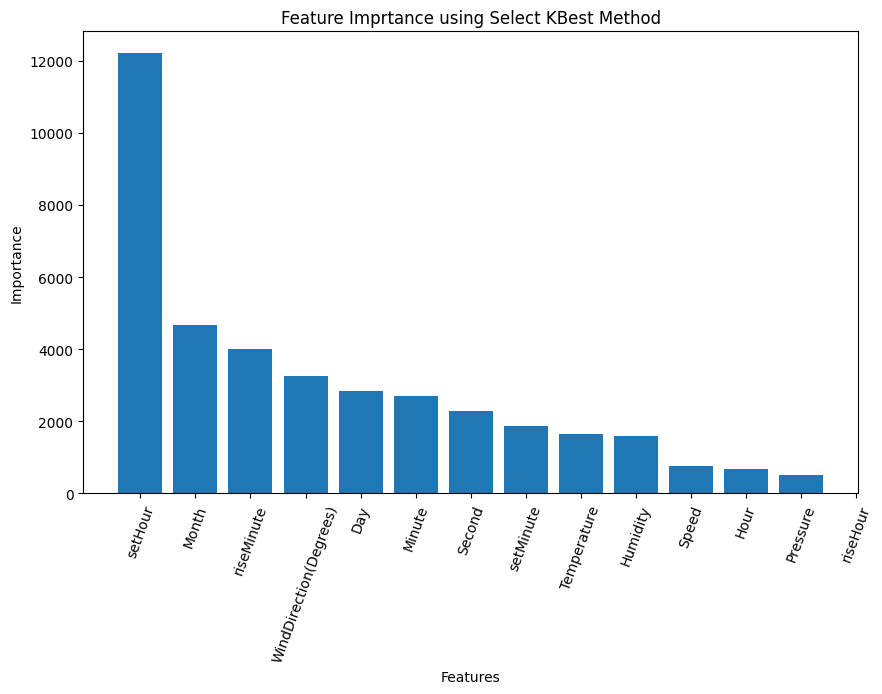

In [29]:
plt.figure(figsize=(10,6))
plt.bar(featureScores.features,featureScores.feature_imp)
plt.xticks(rotation=70)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Imprtance using Select KBest Method')
plt.show()

## Feature Selection using ExtraTree Classifier <a name="extratree"></a>

Bagging model where you run some trees in parallel and get best outcome of all 

Prepare data samples on all these samples prepare decision trees combine result of all these trees to give stronger model

In [30]:
# verbose will show the trees thats building up
model = ExtraTreesClassifier(n_estimators=4,verbose=2)
model.fit(scaled_input_features,target_count)

building tree 1 of 4
building tree 2 of 4
building tree 3 of 4
building tree 4 of 4


ExtraTreesClassifier(n_estimators=4, verbose=2)

In [31]:
feature_importances = pd.DataFrame(model.feature_importances_,index=input_features.columns,columns=['feature_imp'])
feature_importances.sort_values(by='feature_imp',ascending=False,inplace=True)
feature_importances

,feature_imp
WindDirection(Degrees),0.156718
Minute,0.148363
Speed,0.124322
Second,0.123641
Humidity,0.106202
Hour,0.086546
Temperature,0.079721
Pressure,0.076043
Day,0.038099
setMinute,0.027807


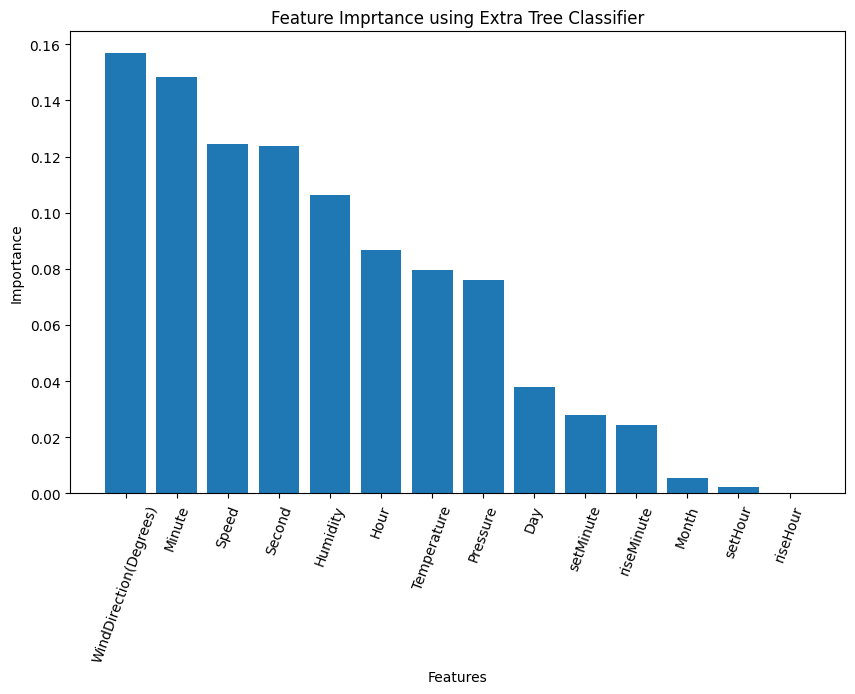

In [32]:
plt.figure(figsize=(10,6))
plt.bar(feature_importances.index,feature_importances.feature_imp)
plt.xticks(rotation=70)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Imprtance using Extra Tree Classifier')
plt.show()

We can observe that both techniques give different importance to features.

We can conclude that our data is not normally distributed.

## Feature Engineering with BoxCox, Log, Min-Max and Standard Transformation <a name="boxcox"></a>

For the features we will visualize their log transformation, standard and MinMax Transformation

We will figure out which of the transformation plot looks like a normal distribution and apply that particular transformation to these features.

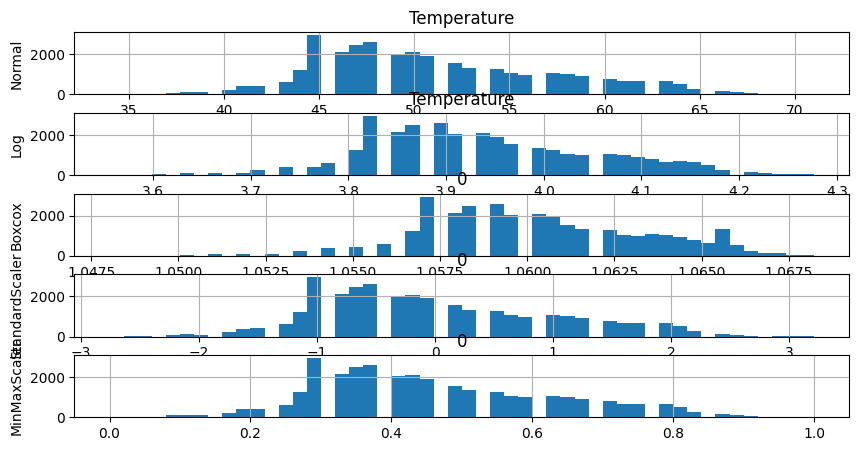

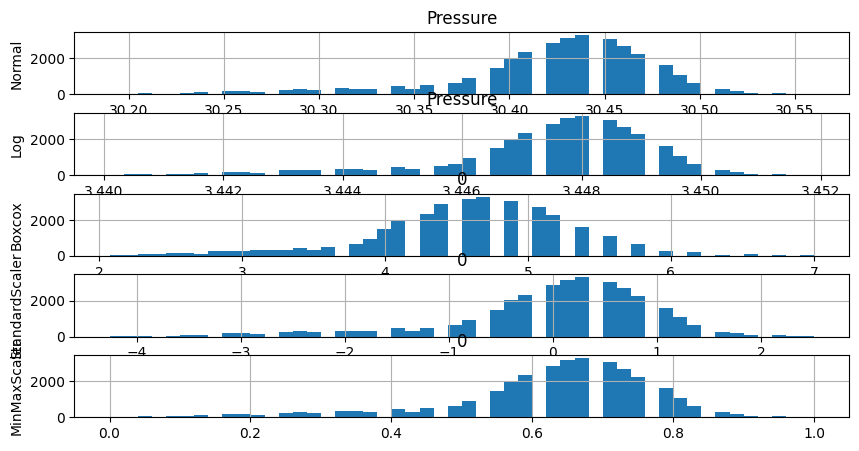

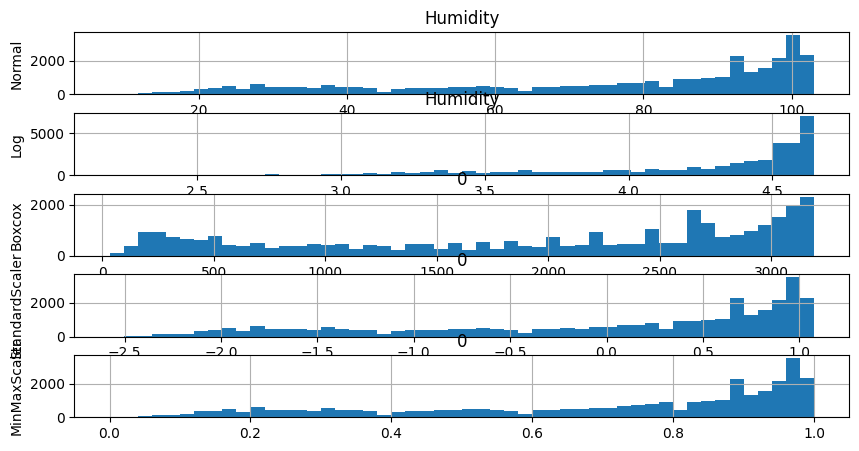

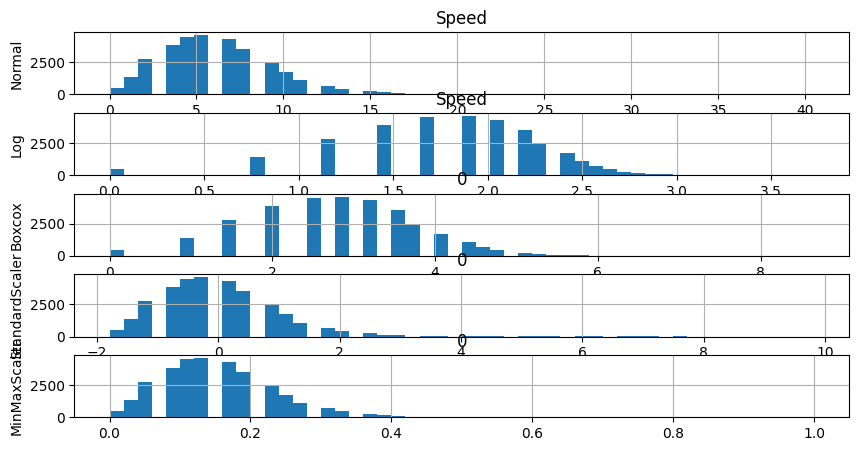

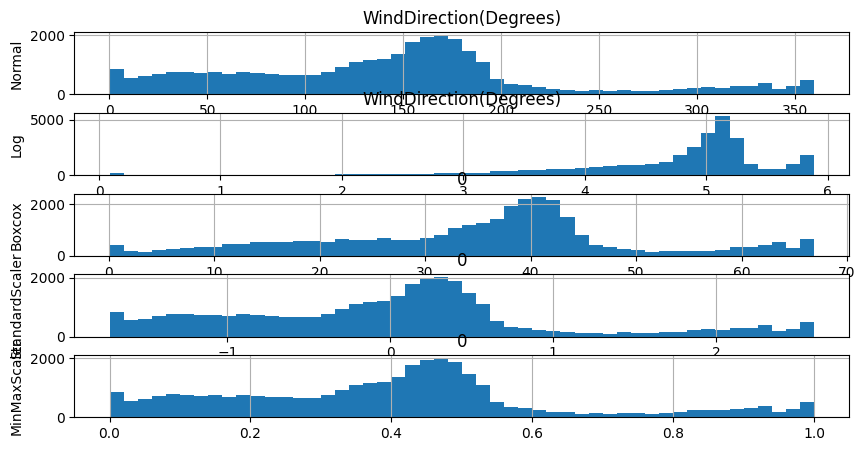

In [33]:
features_to_transform = ['Temperature','Pressure','Humidity','Speed','WindDirection(Degrees)']
for i in features_to_transform:
    # Defining no. of axes that we want
    fig,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(5,1,figsize=(10,5))
    
    # normal
    pd.DataFrame(input_features[i]).hist(ax = ax1,bins = 50)
    # Log transformation
    pd.DataFrame((input_features[i]+1).transform(np.log)).hist(ax = ax2,bins = 50)
    # Boxcox transformation : Puts different powers to your function
    pd.DataFrame(stats.boxcox(input_features[i]+1)[0]).hist(ax = ax3,bins = 50)
    
    pd.DataFrame(StandardScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax = ax4,bins = 50)
    pd.DataFrame(MinMaxScaler().fit_transform(np.array(input_features[i]).reshape(-1,1))).hist(ax = ax5,bins = 50)
                 
    ax1.set_ylabel("Normal")
    ax2.set_ylabel("Log")
    ax3.set_ylabel("Boxcox")
    ax4.set_ylabel("StandardScaler")
    ax5.set_ylabel("MinMaxScaler")

By visualizing the plots, and figure out which transformation is a noraml distribution we will be applying the transformation to the features.

Preparing a data dictionary

In [34]:
transform = {'Temperature':(input_features['Temperature']+1).transform(np.log),
             'Pressure'   : stats.boxcox(input_features['Pressure']+1)[0],
             'Humidity'   : stats.boxcox(input_features['Humidity']+1)[0],
             'Speed'      : (input_features['Speed']+1).transform(np.log), 
             'WindDirection(Degrees)' : MinMaxScaler().fit_transform(
                 np.array(input_features['WindDirection(Degrees)']).reshape(-1,1))}

In [35]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,riseHour,riseMinute,setHour,setMinute
0,48,30.46,59,177.39,5.62,9,29,23,55,26,6,13,18,13
1,48,30.46,58,176.78,3.37,9,29,23,50,23,6,13,18,13
2,48,30.46,57,158.75,3.37,9,29,23,45,26,6,13,18,13
3,48,30.46,60,137.71,3.37,9,29,23,40,21,6,13,18,13
4,48,30.46,62,104.95,5.62,9,29,23,35,24,6,13,18,13


In [36]:
for i in transform:
    input_features[i] = transform[i]

**Data after applying transformation.**

In [37]:
input_features.head()

,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,Month,Day,Hour,Minute,Second,riseHour,riseMinute,setHour,setMinute
0,3.89182,5.044903e+152,1139.358507,0.492692,1.890095,9,29,23,55,26,6,13,18,13
1,3.89182,5.044903e+152,1104.046828,0.490996,1.474763,9,29,23,50,23,6,13,18,13
2,3.89182,5.044903e+152,1069.253399,0.440894,1.474763,9,29,23,45,26,6,13,18,13
3,3.89182,5.044903e+152,1175.187326,0.382426,1.474763,9,29,23,40,21,6,13,18,13
4,3.89182,5.044903e+152,1248.392038,0.291391,1.890095,9,29,23,35,24,6,13,18,13


## Preparing Data - Standardizing and Splitting <a name="standardize"></a>

In [38]:
X_train,X_test,y_train,y_test = train_test_split(input_features,target,test_size=0.2,random_state=1)
sc      = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [39]:
X_train.shape,X_test.shape

((26148, 14), (6538, 14))

## XGBoost <a name="xgboost"></a>

We will take a sample dataset obtain the result put that into sample model obtain new results put it into next sample model and do on..

In [40]:
from xgboost import XGBRegressor
params = {
    'learning_rate':0.1,
    'max_depth'    :8
}

model = XGBRegressor(**params)

In [41]:
model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [42]:
y_pred = model.predict(X_test)

In [43]:
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
# Whether the model is fitting
r2   = r2_score(y_test,y_pred)

print("Testing performance")

print("RMSE {:.2f}".format(rmse))
print("R2 : {:.2f}".format(r2))


Testing performance
RMSE 81.87
R2 : 0.93


## Using Multilayer Perceptron for Prediction <a name="perceptron"></a>

In [44]:
# Initialising the model
model = None
# Sequential : Placeholder for layers where you will be adding your model
model = Sequential()
# Adding 128 neuron in input layer
# input_dim : no of input features
model.add(Dense(128,activation='relu',input_dim=14))
# We dropout some neurons so that model tries to build up again and does not cram the result
model.add(Dropout(0.33))

# Since the sequential model knows how the features are coming we don't need to input it
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.33))
          
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.33))

model.add(Dense(1,activation='relu'))
          
model.compile(metrics='mse',loss='mae',optimizer=Adam(learning_rate=0.001))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1920      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [45]:
# Training the model
# 10% of training data will be for validation at the time of learning
history = model.fit(X_train,y_train,validation_split=0.1,epochs=50,batch_size=32)

Epoch 1/50
736/736 [==============================] - 5s 4ms/step - loss: 123.5102 - mse: 57559.5977 - val_loss: 77.7610 - val_mse: 22679.8418
Epoch 2/50
736/736 [==============================] - 3s 4ms/step - loss: 84.6782 - mse: 26523.2285 - val_loss: 70.4459 - val_mse: 18534.5098
Epoch 3/50
736/736 [==============================] - 2s 3ms/step - loss: 81.1655 - mse: 24539.5254 - val_loss: 65.0893 - val_mse: 15948.3535
Epoch 4/50
736/736 [==============================] - 2s 3ms/step - loss: 78.3411 - mse: 23197.7930 - val_loss: 64.0398 - val_mse: 16092.6318
Epoch 5/50
736/736 [==============================] - 2s 3ms/step - loss: 75.3218 - mse: 21879.8242 - val_loss: 58.9176 - val_mse: 14002.0654
Epoch 6/50
736/736 [==============================] - 2s 3ms/step - loss: 72.6615 - mse: 20749.1035 - val_loss: 57.6681 - val_mse: 13789.8125
Epoch 7/50
736/736 [==============================] - 2s 3ms/step - loss: 72.1267 - mse: 20441.2520 - val_loss: 56.3166 - val_mse: 13301.7373
Epoch

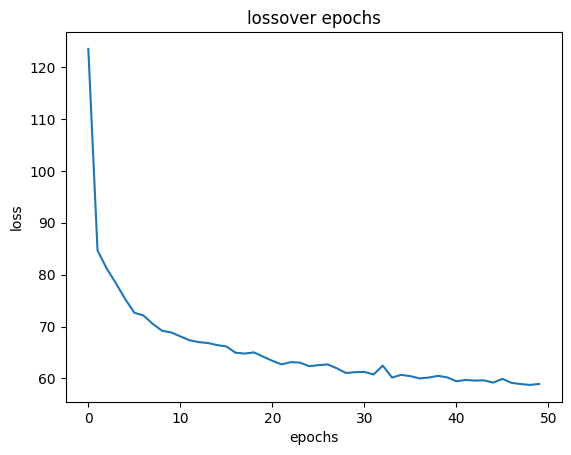

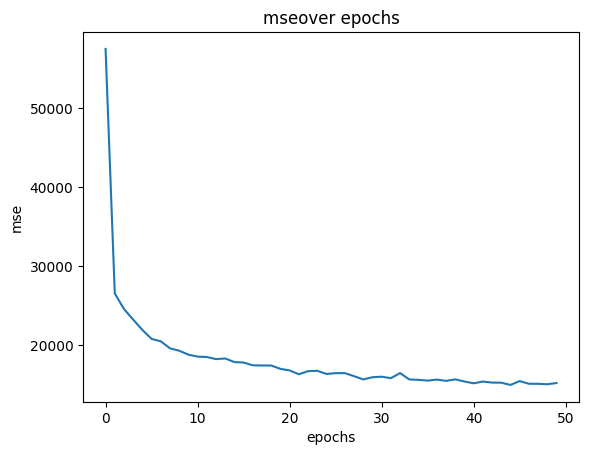

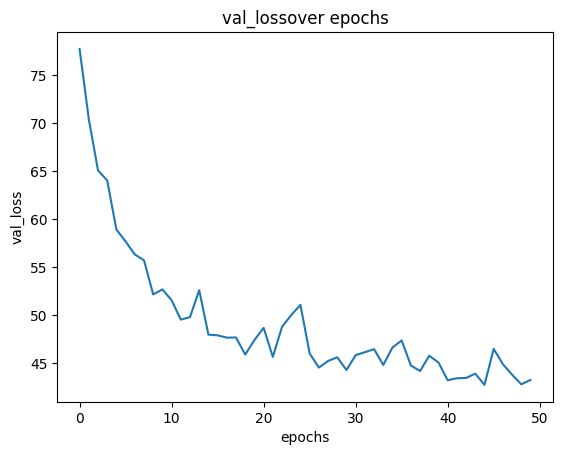

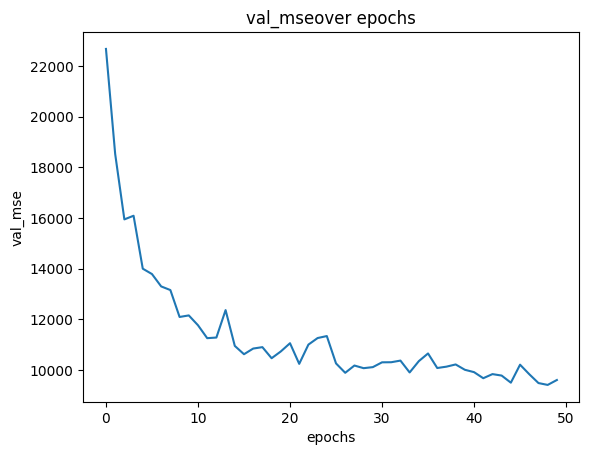

In [46]:
# list of all losses,mse, validation losses..
fit = history.history
for i in fit:
    plt.plot(fit[i])
    plt.title(i+'over epochs')
    plt.ylabel(i)
    plt.xlabel('epochs')
    plt.show()

In [47]:
y_pred = model.predict(X_test)

205/205 [==============================] - 0s 1ms/step


In [48]:
mean_absolute_error(y_test,y_pred)

41.74354288106812